In [29]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [30]:
# Load the dataset
df = pd.read_csv('Telco Customer Churn.csv')

# Display information
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

Dataset Shape: (7043, 21)

First 5 rows:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport Streami

In [31]:
print("\nDataset Info:")
print(df.info())

print("\nMissing values:")
print(df.isnull().sum())

print("\nDataset description:")
print(df.describe())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-

In [32]:
# Data preprocessing function
def preprocess_data(df):
    # Create a copy
    data = df.copy()

    # Drop customerID as it's not useful for prediction
    data = data.drop('customerID', axis=1)

    # Convert TotalCharges to numeric, handling spaces
    data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

    # Fill missing values in TotalCharges with median
    data['TotalCharges'] = data['TotalCharges'].fillna(data['TotalCharges'].median())

    # Convert Churn to binary
    data['Churn'] = data['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

    # Convert SeniorCitizen to object for proper encoding
    data['SeniorCitizen'] = data['SeniorCitizen'].astype('object')

    return data

# Apply preprocessing
df_processed = preprocess_data(df)

In [33]:
# Identify column types: categorical and numerical columns
categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)

Categorical columns: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numerical columns: ['tenure', 'MonthlyCharges', 'TotalCharges']


In [34]:
# Encode categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col])
    label_encoders[col] = le

# Feature-target split
X = df_processed.drop('Churn', axis=1)
y = df_processed['Churn']

print(f"\nClass distribution:\n{y.value_counts()}")
print(f"Churn rate: {y.mean():.2%}")


Class distribution:
Churn
0    5174
1    1869
Name: count, dtype: int64
Churn rate: 26.54%


In [35]:
# Handle class imbalance (using SMOTE) and split data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
print(f"Resampled class distribution:\n{pd.Series(y_resampled).value_counts()}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Scale numerical features
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Resampled class distribution:
Churn
0    5174
1    5174
Name: count, dtype: int64

Training set shape: (8278, 19)
Test set shape: (2070, 19)


In [36]:
# Initialize models with balanced class weights
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False),
    'LightGBM': LGBMClassifier(random_state=42, class_weight='balanced'),
    'SVM': SVC(random_state=42, probability=True, class_weight='balanced')
}

In [37]:
# Train and evaluate models
results = {}
feature_importances = {}

for model_name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training {model_name}...")

    # Train model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    # Store results
    results[model_name] = {
        'accuracy': accuracy,
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1_score': report['weighted avg']['f1-score'],
        'model': model
    }

    # Store feature importances for tree-based models
    if hasattr(model, 'feature_importances_'):
        feature_importances[model_name] = pd.DataFrame({
            'feature': X.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {report['weighted avg']['precision']:.4f}")
    print(f"Recall: {report['weighted avg']['recall']:.4f}")
    print(f"F1-Score: {report['weighted avg']['f1-score']:.4f}")

    # ROC-AUC if probabilities available
    if y_pred_proba is not None:
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        results[model_name]['roc_auc'] = roc_auc
        print(f"ROC-AUC: {roc_auc:.4f}")


Training Logistic Regression...
Accuracy: 0.8058
Precision: 0.8075
Recall: 0.8058
F1-Score: 0.8055
ROC-AUC: 0.8910

Training Decision Tree...
Accuracy: 0.8014
Precision: 0.8016
Recall: 0.8014
F1-Score: 0.8014
ROC-AUC: 0.8024

Training Random Forest...
Accuracy: 0.8498
Precision: 0.8499
Recall: 0.8498
F1-Score: 0.8497
ROC-AUC: 0.9289

Training Gradient Boosting...
Accuracy: 0.8324
Precision: 0.8338
Recall: 0.8324
F1-Score: 0.8322
ROC-AUC: 0.9196

Training XGBoost...
Accuracy: 0.8488
Precision: 0.8489
Recall: 0.8488
F1-Score: 0.8488
ROC-AUC: 0.9276

Training LightGBM...
[LightGBM] [Info] Number of positive: 4139, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003930 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 627
[LightGBM] [Info] Number of data points in the train set: 8278, number of used features: 19
[Lig

In [38]:
# Compare model performance
print("\n" + "="*60)
print("MODEL PERFORMANCE COMPARISON")
print("="*60)

results_df = pd.DataFrame(results).T
results_df = results_df[['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']].round(4)
results_df = results_df.sort_values('accuracy', ascending=False)
print(results_df)


MODEL PERFORMANCE COMPARISON
                     accuracy precision    recall  f1_score   roc_auc
Random Forest        0.849758  0.849903  0.849758  0.849743  0.928918
XGBoost              0.848792  0.848886  0.848792  0.848782  0.927583
LightGBM             0.843478  0.843663  0.843478  0.843457  0.928565
Gradient Boosting    0.832367  0.833766  0.832367  0.832191  0.919558
SVM                  0.829952  0.830052  0.829952  0.829939  0.910921
Logistic Regression  0.805797  0.807544  0.805797  0.805521  0.890988
Decision Tree        0.801449  0.801598  0.801449  0.801425  0.802403


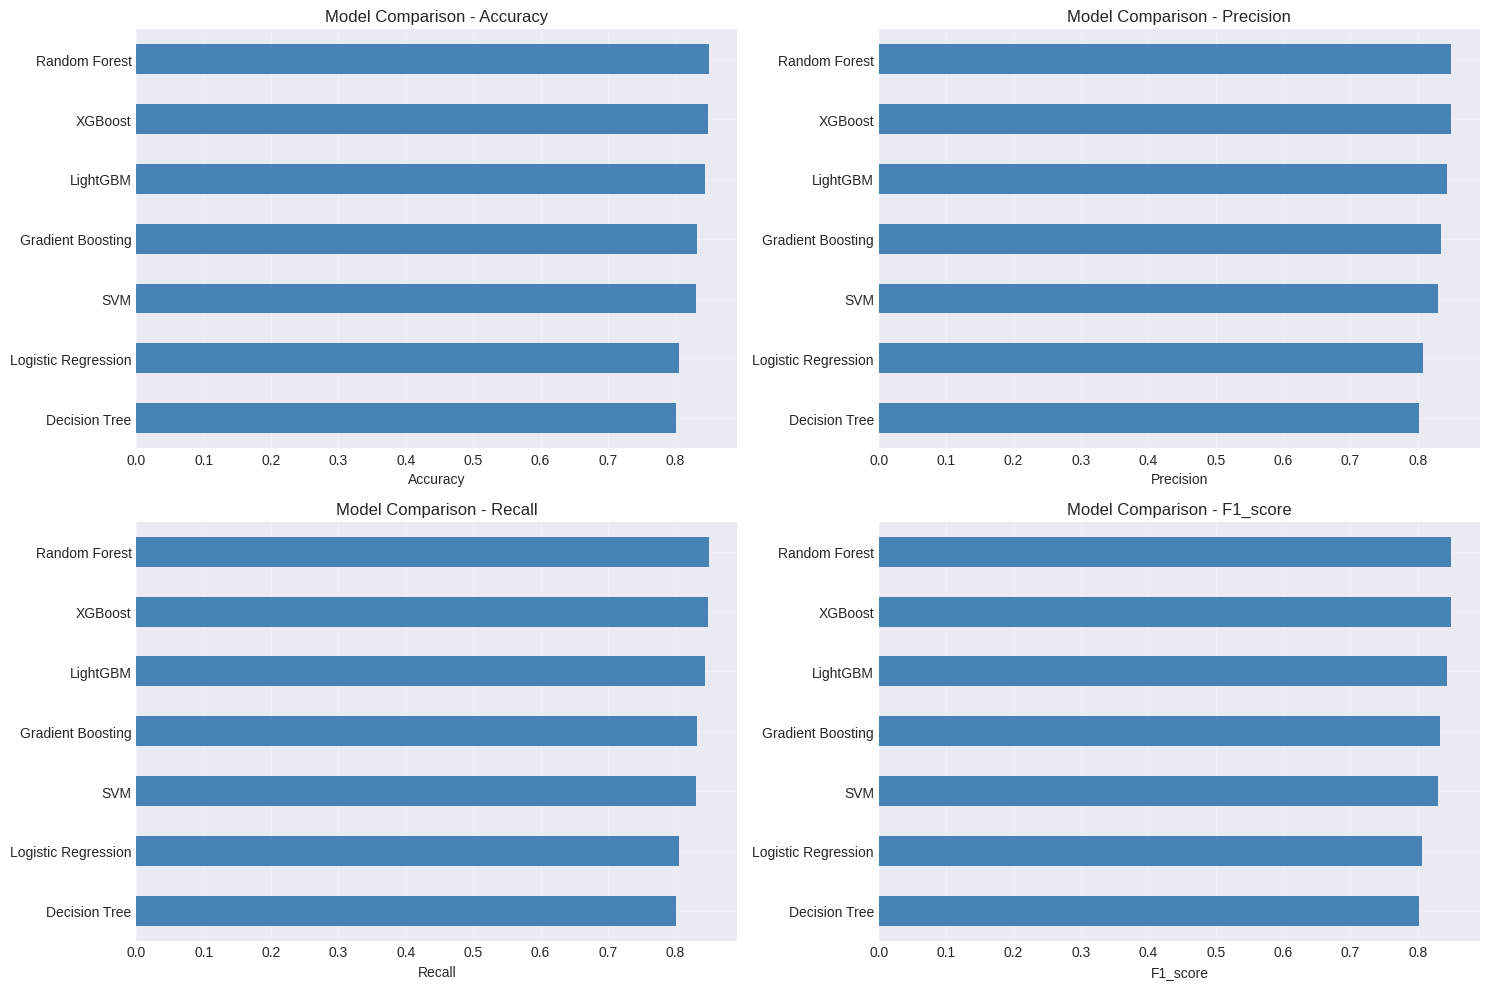

In [39]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
metrics = ['accuracy', 'precision', 'recall', 'f1_score']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    results_df[metric].sort_values().plot(kind='barh', ax=ax, color='steelblue')
    ax.set_title(f'Model Comparison - {metric.capitalize()}')
    ax.set_xlabel(metric.capitalize())
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Top 10 Feature Importances from Random Forest:
             feature  importance
17    MonthlyCharges    0.139068
18      TotalCharges    0.134694
14          Contract    0.129548
4             tenure    0.118827
8     OnlineSecurity    0.087872
11       TechSupport    0.084092
9       OnlineBackup    0.044665
16     PaymentMethod    0.041877
2            Partner    0.027166
10  DeviceProtection    0.027027


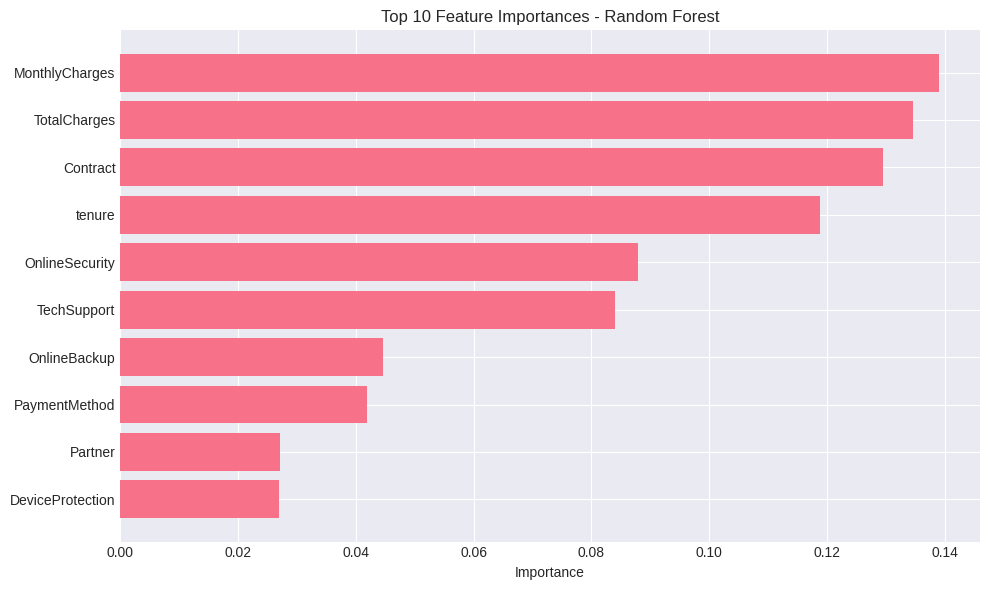

In [40]:
# Display feature importance from best tree-based model
if feature_importances:
    best_tree_model = results_df.index[0]
    if best_tree_model in feature_importances:
        print(f"\nTop 10 Feature Importances from {best_tree_model}:")
        print(feature_importances[best_tree_model].head(10))

        # Visualize feature importance
        plt.figure(figsize=(10, 6))
        top_features = feature_importances[best_tree_model].head(10)
        plt.barh(range(len(top_features)), top_features['importance'][::-1])
        plt.yticks(range(len(top_features)), top_features['feature'][::-1])
        plt.xlabel('Importance')
        plt.title(f'Top 10 Feature Importances - {best_tree_model}')
        plt.tight_layout()
        plt.show()


DETAILED ANALYSIS OF BEST MODEL: Random Forest


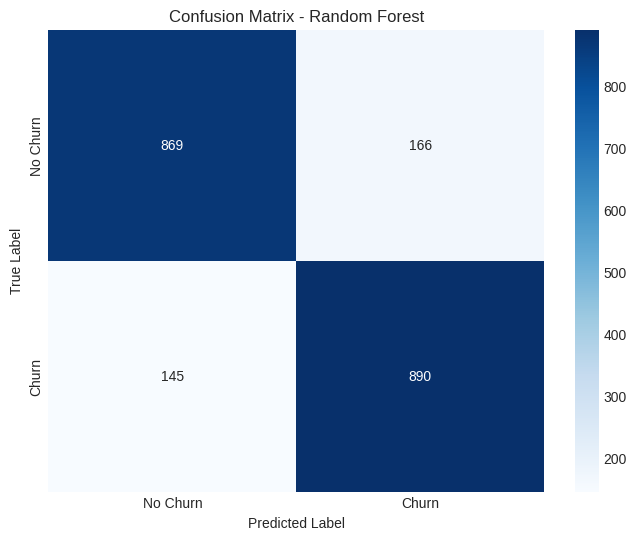

In [41]:
# Detailed analysis of best model
best_model_name = results_df.index[0]
best_model = results[best_model_name]['model']

print(f"\n{'='*60}")
print(f"DETAILED ANALYSIS OF BEST MODEL: {best_model_name}")
print("="*60)

# Confusion Matrix
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [42]:
# Classification report for best model
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1035
           1       0.84      0.86      0.85      1035

    accuracy                           0.85      2070
   macro avg       0.85      0.85      0.85      2070
weighted avg       0.85      0.85      0.85      2070



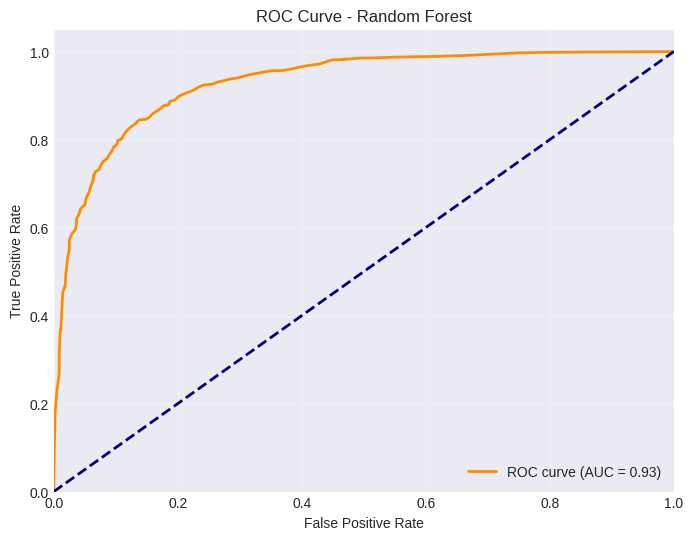

In [43]:
# ROC Curve for best model
if hasattr(best_model, "predict_proba"):
    y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_best)
    roc_auc = roc_auc_score(y_test, y_pred_proba_best)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {best_model_name}')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()

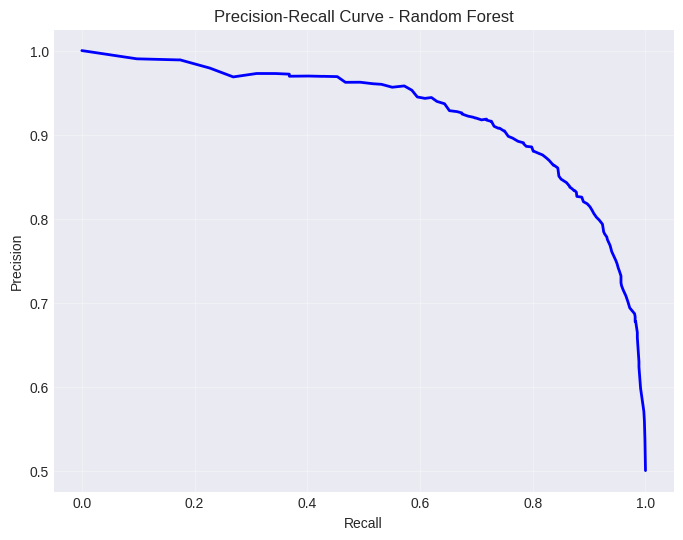

In [44]:
#Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_best)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve - {best_model_name}')
plt.grid(True, alpha=0.3)
plt.show()

In [45]:
# Hyperparameter tuning for the best model
print(f"\nPerforming hyperparameter tuning for {best_model_name}...")

if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

elif best_model_name == 'XGBoost':
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0]
    }

elif best_model_name == 'LightGBM':
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [5, 10, -1],
        'learning_rate': [0.01, 0.1, 0.2],
        'num_leaves': [31, 50, 100]
    }

elif best_model_name == 'Logistic Regression':
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }

if best_model_name in ['Random Forest', 'XGBoost', 'LightGBM', 'Logistic Regression']:
    grid_search = GridSearchCV(
        best_model,
        param_grid,
        cv=3,
        scoring='f1',
        n_jobs=-1,
        verbose=0
    )

    grid_search.fit(X_train, y_train)

    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")

    # Evaluate tuned model
    best_tuned_model = grid_search.best_estimator_
    y_pred_tuned = best_tuned_model.predict(X_test)

    print("\nTuned Model Performance:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_tuned):.4f}")
    print(f"F1-Score: {classification_report(y_test, y_pred_tuned, output_dict=True)['weighted avg']['f1-score']:.4f}")


Performing hyperparameter tuning for Random Forest...
Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best CV score: 0.8480

Tuned Model Performance:
Accuracy: 0.8454
F1-Score: 0.8454



BUSINESS INSIGHTS AND RECOMMENDATIONS


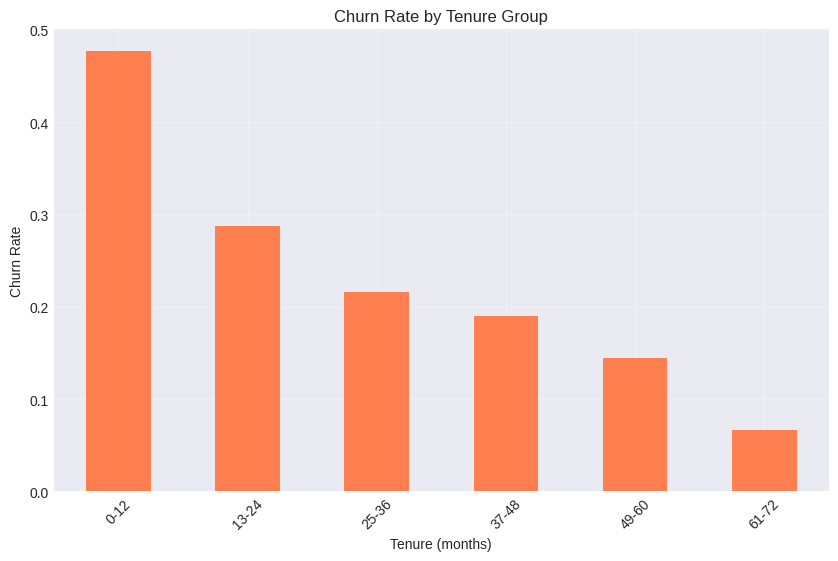

In [46]:
# Business insights and recommendations
print("\n" + "="*60)
print("BUSINESS INSIGHTS AND RECOMMENDATIONS")
print("="*60)

# Calculate churn rate by tenure groups
df_processed['tenure_group'] = pd.cut(df_processed['tenure'],
                                      bins=[0, 12, 24, 36, 48, 60, 72],
                                      labels=['0-12', '13-24', '25-36', '37-48', '49-60', '61-72'])
churn_by_tenure = df_processed.groupby('tenure_group')['Churn'].mean()

plt.figure(figsize=(10, 6))
churn_by_tenure.plot(kind='bar', color='coral')
plt.title('Churn Rate by Tenure Group')
plt.xlabel('Tenure (months)')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

In [47]:
# Key findings and recommendations
print("\nKey Findings:")
print("1. Early tenure customers (0-12 months) have the highest churn rate")
print("2. Long-term customers (60+ months) have significantly lower churn rates")
print("3. Monthly charges and contract type are strong predictors of churn")

print("\nRecommendations:")
print("1. Focus retention efforts on customers in their first year")
print("2. Consider offering incentives for longer contract commitments")
print("3. Monitor customers with high monthly charges for proactive engagement")
print("4. Implement early warning systems based on the predictive model")


Key Findings:
1. Early tenure customers (0-12 months) have the highest churn rate
2. Long-term customers (60+ months) have significantly lower churn rates
3. Monthly charges and contract type are strong predictors of churn

Recommendations:
1. Focus retention efforts on customers in their first year
2. Consider offering incentives for longer contract commitments
3. Monitor customers with high monthly charges for proactive engagement
4. Implement early warning systems based on the predictive model


In [50]:
# Cell 20: Save model and create prediction function
import joblib

# Save the best model and preprocessing objects
joblib.dump(best_model, 'best_churn_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')

print("Model and preprocessing objects saved:")
print("- best_churn_model.pkl")
print("- scaler.pkl")
print("- label_encoders.pkl")

# Create a modified preprocessing function for predictions
def preprocess_for_prediction(df):
    """Preprocess data specifically for prediction"""
    data = df.copy()

    # Drop customerID if it exists
    if 'customerID' in data.columns:
        data = data.drop('customerID', axis=1)

    # Convert TotalCharges to numeric, handling spaces
    data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

    # Fill missing values in TotalCharges with median from training data
    data['TotalCharges'] = data['TotalCharges'].fillna(df_processed['TotalCharges'].median())

    # Convert SeniorCitizen to object for proper encoding
    if 'SeniorCitizen' in data.columns:
        data['SeniorCitizen'] = data['SeniorCitizen'].astype('object')

    return data

# Create a sample prediction function
def predict_churn(customer_data):
    """Predict churn probability for a new customer"""
    # Create a DataFrame from the input
    input_df = pd.DataFrame([customer_data])

    # Apply preprocessing for prediction
    input_df = preprocess_for_prediction(input_df)

    # Ensure all required columns exist
    for col in X.columns:
        if col not in input_df.columns:
            # Add missing columns with default values
            input_df[col] = 0

    # Encode categorical variables
    for col in categorical_cols:
        if col in input_df.columns:
            le = label_encoders[col]
            # Handle unseen labels by using most common class
            try:
                input_df[col] = le.transform(input_df[col])
            except ValueError:
                # If label is not seen during training, use the most common class (0)
                input_df[col] = 0

    # Scale numerical features
    input_df[numerical_cols] = scaler.transform(input_df[numerical_cols])

    # Make prediction
    churn_probability = best_model.predict_proba(input_df)[0][1]
    churn_prediction = best_model.predict(input_df)[0]

    return {
        'churn_probability': churn_probability,
        'will_churn': bool(churn_prediction),
        'risk_level': 'High' if churn_probability > 0.7 else 'Medium' if churn_probability > 0.3 else 'Low'
    }

# Test prediction
example_customer = {
    'gender': 'Male',
    'SeniorCitizen': 0,
    'Partner': 'Yes',
    'Dependents': 'No',
    'tenure': 2,
    'PhoneService': 'Yes',
    'MultipleLines': 'No',
    'InternetService': 'Fiber optic',
    'OnlineSecurity': 'No',
    'OnlineBackup': 'No',
    'DeviceProtection': 'No',
    'TechSupport': 'No',
    'StreamingTV': 'No',
    'StreamingMovies': 'No',
    'Contract': 'Month-to-month',
    'PaperlessBilling': 'Yes',
    'PaymentMethod': 'Electronic check',
    'MonthlyCharges': 70.70,
    'TotalCharges': 151.65
}

prediction = predict_churn(example_customer)
print(f"\nExample Prediction:")
print(f"Churn Probability: {prediction['churn_probability']:.2%}")
print(f"Predicted to Churn: {prediction['will_churn']}")
print(f"Risk Level: {prediction['risk_level']}")

Model and preprocessing objects saved:
- best_churn_model.pkl
- scaler.pkl
- label_encoders.pkl

Example Prediction:
Churn Probability: 57.00%
Predicted to Churn: True
Risk Level: Medium
